<a href="https://colab.research.google.com/github/rhks13/DART/blob/main/%EC%82%AC%EA%B1%B4%EC%97%B0%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 추정기간 어떻게 설정 ? 
# 선행연구 따르면 사건기간 : 사건일 전후 1일 (-1, 0, 1) / 추정기간 (-120~-2)
# 알아서 조정.. 20영업일?

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
kospi = pd.read_excel('/content/drive/MyDrive/DART/레포트/data/코스피 수익률.xlsx',index_col=0)
battery = pd.read_excel('/content/drive/MyDrive/DART/레포트/data/2차전지-수익률.xlsx',index_col=0)
solar = pd.read_excel('/content/drive/MyDrive/DART/레포트/data/태양광-수익률.xlsx',index_col=0)
wind = pd.read_excel('/content/drive/MyDrive/DART/레포트/data/풍력-수익률.xlsx',index_col=0)
event_news = pd.read_excel('/content/drive/MyDrive/DART/레포트/data/일자별-이슈.xlsx')

In [ ]:
from datetime import datetime
import requests
import json
from pandas import json_normalize

## **비영업일 생성하기**

In [ ]:
# 공휴일 받아오기 -> pytimekr은 연례 공휴일만 포함 => 한국천문연구원_특일 정보에서 역대 공휴일 얻어오기
# 우선 2014년 공휴일 받아오기
today = datetime.today().strftime('%Y%m%d')
key = 'itBvQCzCuulLjfjgQsV84rB1S%2F5sCs%2BWqzV9Q%2F3QXs7cvXztbFG5mCFF%2BaCX9zBGepmqRYuev0r63U8xJeBpuQ%3D%3D'
url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(2014) + '&ServiceKey=' + str(key)
response = requests.get(url)
if response.status_code == 200:
	json_ob = json.loads(response.text)
	holidays_data = json_ob['response']['body']['items']['item']
	dataframe = json_normalize(holidays_data)
dateName = dataframe.loc[dataframe['locdate'] == int(today), 'dateName']

print(dataframe)

   dateKind dateName isHoliday   locdate  seq
0        01       신정         Y  20140101    1
1        01       설날         Y  20140130    1
2        01       설날         Y  20140131    1
3        01       설날         Y  20140201    1
4        01      삼일절         Y  20140301    1
5        01     어린이날         Y  20140505    1
6        01    석가탄신일         Y  20140506    1
7        01  동시지방선거일         Y  20140604    1
8        01      현충일         Y  20140606    1
9        01      광복절         Y  20140815    1
10       01       추석         Y  20140907    1
11       01       추석         Y  20140908    1
12       01       추석         Y  20140909    1
13       01    대체공휴일         Y  20140910    1
14       01      개천절         Y  20141003    1
15       01      한글날         Y  20141009    1
16       01    기독탄신일         Y  20141225    1


In [ ]:
# 초기 데이터 생성
origin = dataframe.copy()

In [ ]:
# 2015년 - 2023년 특일 데이터 생성해서 concat
today = datetime.today().strftime('%Y%m%d')
year = range(2015,2023)
for i in year:
  key = 'itBvQCzCuulLjfjgQsV84rB1S%2F5sCs%2BWqzV9Q%2F3QXs7cvXztbFG5mCFF%2BaCX9zBGepmqRYuev0r63U8xJeBpuQ%3D%3D'
  url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(i) + '&ServiceKey=' + str(key)
  response = requests.get(url)
  if response.status_code == 200:
    json_ob = json.loads(response.text)
    holidays_data = json_ob['response']['body']['items']['item']
    dataframe = json_normalize(holidays_data)
  dateName = dataframe.loc[dataframe['locdate'] == int(today), 'dateName']
  origin = pd.concat([origin, dataframe])

In [ ]:
# 최종 특일 데이터
origin

,dateKind,dateName,isHoliday,locdate,seq
0,01,신정,Y,20140101,1
1,01,설날,Y,20140130,1
2,01,설날,Y,20140131,1
3,01,설날,Y,20140201,1
4,01,삼일절,Y,20140301,1
...,...,...,...,...,...
14,01,대체공휴일,Y,20220912,1
15,01,개천절,Y,20221003,1
16,01,한글날,Y,20221009,1
17,01,대체공휴일,Y,20221010,3


In [ ]:
# 일자만 빼오기
holi = origin['locdate'].reset_index()['locdate']
holi

0      20140101
1      20140130
2      20140131
3      20140201
4      20140301
         ...   
153    20220912
154    20221003
155    20221009
156    20221010
157    20221225
Name: locdate, Length: 158, dtype: int64

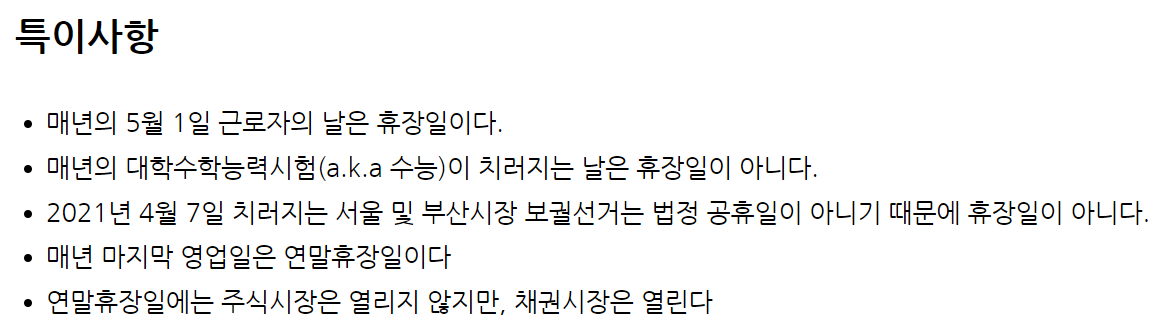

In [ ]:
# 매년 마지막 영업일 &근로자의날 (5/1)에는 장이 열리지 않아 -> 직접 손수 추가
new = [20141231,20151231,20161230,20171229,20181231,20191231,20201231,20211231,20221231,20140501,20150501,20160501,20170501,20180501,20190501,20200501,20210501,20220501]
for i in range(175, 193):
  holi[i] = new[i-175]

In [ ]:
# 최종 14-22 비영업일 생성
holi

0      20140101
1      20140130
2      20140131
3      20140201
4      20140301
         ...   
188    20180501
189    20190501
190    20200501
191    20210501
192    20220501
Name: locdate, Length: 176, dtype: int64

In [ ]:
# datetime 형식으로 바꿔주는 작업
def hol(i):
  return str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:]
  holi = pd.to_datetime(holi.apply(hol))
  holi

In [ ]:
holi = holi.apply(hol)
holi

0      2014-01-01
1      2014-01-30
2      2014-01-31
3      2014-02-01
4      2014-03-01
          ...    
188    2018-05-01
189    2019-05-01
190    2020-05-01
191    2021-05-01
192    2022-05-01
Name: locdate, Length: 176, dtype: object

# **Event별 추정기간 / 사건기간의 구분**

In [ ]:
event=event_news.iloc[:,0]
event

0    2015-01-14
1    2015-02-02
2    2015-03-31
3    2015-03-27
4    2015-12-12
5    2016-02-01
6    2016-07-06
7    2016-08-16
8    2016-11-07
9    2016-11-14
10   2016-11-18
11   2017-06-01
12   2017-01-23
13   2017-11-06
14   2018-01-10
15   2018-11-29
16   2018-12-02
17   2019-06-04
18   2019-12-02
19   2019-12-11
20   2020-05-20
21   2020-06-01
22   2020-07-14
23   2020-09-22
24   2020-12-16
25   2021-01-21
26   2021-07-14
27   2021-07-28
28   2021-10-28
29   2021-10-31
30   2022-03-22
31   2022-05-18
32   2022-06-23
33   2022-08-07
34   2022-11-03
Name: 날짜 , dtype: datetime64[ns]

In [ ]:
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import MonthEnd

In [ ]:

# callist = []
# eventlist = []
# for i in range(len(event)):
#   추정시작 = (event[i] - BDay(40)).strftime('%Y-%m-%d')
#   추정끝 = (event[i] - BDay(3)).strftime('%Y-%m-%d')
#   사건시작 = (event[i] - BDay(2)).strftime('%Y-%m-%d')
#   사건끝 = (event[i] + BDay(2)).strftime('%Y-%m-%d')
#   추정기간 = pd.bdate_range(start = 추정시작, end = 추정끝, freq='C', holidays = holi)
#   사건기간 = pd.bdate_range(start = 사건시작, end = 사건끝, freq='C', holidays = holi)
#   callist.append(추정기간)
#   eventlist.append(사건기간)

In [ ]:
# 이렇게 그냥돌리면 nan값 생겨 -> 수익률 데이터들은 모두 영업일 기준으로 생성 -> 영업일 기준으로 date_range 계산해야

In [ ]:
# 비영업일에 발표된 event days들도 존재 -> 가장빠른 다음 영업일로 직접 조정

In [ ]:
event[4] = '2015-12-14 00:00:00'
event[16] = '2018-12-04 00:00:00'
event[29] = '2021-11-01 00:00:00'
event[33] = '2022-08-08 00:00:00'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
callist = []
eventlist = []
for i in range(len(event)):
  사건당일 = event[i]
  추정기간 = pd.bdate_range(end = 사건당일, periods =40, freq='C', holidays = holi)
  사건기간 = pd.bdate_range(start = 사건당일, periods=3, freq='C', holidays = holi)
  callist.append(추정기간[:-1])
  eventlist.append(사건기간)

In [ ]:
calday=pd.DataFrame(callist).T
evday=pd.DataFrame(eventlist).T

In [ ]:
print(evday.isnull().sum().sum())
print(calday.isnull().sum().sum())

0
0


In [ ]:
evday

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2015-01-14,2015-02-02,2015-03-31,2015-03-27,2015-12-14,2016-02-01,2016-07-06,2016-08-16,2016-11-07,2016-11-14,...,2021-01-21,2021-07-14,2021-07-28,2021-10-28,2021-11-01,2022-03-22,2022-05-18,2022-06-23,2022-08-08,2022-11-03
1,2015-01-15,2015-02-03,2015-04-01,2015-03-30,2015-12-15,2016-02-02,2016-07-07,2016-08-17,2016-11-08,2016-11-15,...,2021-01-22,2021-07-15,2021-07-29,2021-10-29,2021-11-02,2022-03-23,2022-05-19,2022-06-24,2022-08-09,2022-11-04
2,2015-01-16,2015-02-04,2015-04-02,2015-03-31,2015-12-16,2016-02-03,2016-07-08,2016-08-18,2016-11-09,2016-11-16,...,2021-01-25,2021-07-16,2021-07-30,2021-11-01,2021-11-03,2022-03-24,2022-05-20,2022-06-27,2022-08-10,2022-11-07


In [ ]:
calday

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2014-11-17,2014-12-04,2015-01-30,2015-01-28,2015-10-20,2015-12-03,2016-05-11,2016-06-21,2016-09-07,2016-09-19,...,2020-11-24,2021-05-20,2021-06-03,2021-08-27,2021-08-31,2022-01-19,2022-03-23,2022-04-26,2022-06-14,2022-09-05
1,2014-11-18,2014-12-05,2015-02-02,2015-01-29,2015-10-21,2015-12-04,2016-05-12,2016-06-22,2016-09-08,2016-09-20,...,2020-11-25,2021-05-21,2021-06-04,2021-08-30,2021-09-01,2022-01-20,2022-03-24,2022-04-27,2022-06-15,2022-09-06
2,2014-11-19,2014-12-08,2015-02-03,2015-01-30,2015-10-22,2015-12-07,2016-05-13,2016-06-23,2016-09-09,2016-09-21,...,2020-11-26,2021-05-24,2021-06-07,2021-08-31,2021-09-02,2022-01-21,2022-03-25,2022-04-28,2022-06-16,2022-09-07
3,2014-11-20,2014-12-09,2015-02-04,2015-02-02,2015-10-23,2015-12-08,2016-05-16,2016-06-24,2016-09-12,2016-09-22,...,2020-11-27,2021-05-25,2021-06-08,2021-09-01,2021-09-03,2022-01-24,2022-03-28,2022-04-29,2022-06-17,2022-09-08
4,2014-11-21,2014-12-10,2015-02-05,2015-02-03,2015-10-26,2015-12-09,2016-05-17,2016-06-27,2016-09-13,2016-09-23,...,2020-11-30,2021-05-26,2021-06-09,2021-09-02,2021-09-06,2022-01-25,2022-03-29,2022-05-02,2022-06-20,2022-09-13
5,2014-11-24,2014-12-11,2015-02-06,2015-02-04,2015-10-27,2015-12-10,2016-05-18,2016-06-28,2016-09-19,2016-09-26,...,2020-12-01,2021-05-27,2021-06-10,2021-09-03,2021-09-07,2022-01-26,2022-03-30,2022-05-03,2022-06-21,2022-09-14
6,2014-11-25,2014-12-12,2015-02-09,2015-02-05,2015-10-28,2015-12-11,2016-05-19,2016-06-29,2016-09-20,2016-09-27,...,2020-12-02,2021-05-28,2021-06-11,2021-09-06,2021-09-08,2022-01-27,2022-03-31,2022-05-04,2022-06-22,2022-09-15
7,2014-11-26,2014-12-15,2015-02-10,2015-02-06,2015-10-29,2015-12-14,2016-05-20,2016-06-30,2016-09-21,2016-09-28,...,2020-12-03,2021-05-31,2021-06-14,2021-09-07,2021-09-09,2022-01-28,2022-04-01,2022-05-06,2022-06-23,2022-09-16
8,2014-11-27,2014-12-16,2015-02-11,2015-02-09,2015-10-30,2015-12-15,2016-05-23,2016-07-01,2016-09-22,2016-09-29,...,2020-12-04,2021-06-01,2021-06-15,2021-09-08,2021-09-10,2022-02-03,2022-04-04,2022-05-09,2022-06-24,2022-09-19
9,2014-11-28,2014-12-17,2015-02-12,2015-02-10,2015-11-02,2015-12-16,2016-05-24,2016-07-04,2016-09-23,2016-09-30,...,2020-12-07,2021-06-02,2021-06-16,2021-09-09,2021-09-13,2022-02-04,2022-04-05,2022-05-10,2022-06-27,2022-09-20


# **정상 / 비정상 기대 수익률 모형 생성 (안돌려도됨)**

In [ ]:
# 정상 기대수익률 모형 추정

In [ ]:
# 추정기간 종가 추정
kospi_nor=kospi.loc[calday.iloc[:,0],'코스피']
kospi_200=kospi.loc[calday.iloc[:,0],'코스피 200']

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
bat_df=battery.loc[calday.iloc[:,1]] # 2차전지 -> 첫번째 이벤트의 추정기간동안의 수익률
bat_df

,SKC,SK이노베이션,삼성SDI,에코프로,엘앤에프,포스코케미칼
date,,,,,,
2014-12-04,1.36,1.54,-1.17,1.20,-2.11,1.28
2014-12-05,0.96,0.70,0.00,0.00,3.15,1.33
2014-12-08,-0.76,0.12,1.19,1.45,0.64,-2.89
2014-12-09,-1.53,-2.20,-3.52,0.65,-1.28,-1.01
2014-12-10,-2.52,-3.08,-1.62,-0.13,-1.94,1.64
2014-12-11,0.00,-1.47,-0.82,0.13,-0.82,-2.62
2014-12-12,-1.39,0.99,4.15,-0.78,-2.33,-1.31
2014-12-15,2.42,4.31,0.00,0.91,-2.55,1.33
2014-12-16,-2.76,0.47,-0.80,-3.49,-4.89,0.00


In [ ]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.506
Date:                Thu, 24 Nov 2022   Prob (F-statistic):             0.0405
Time:                        01:17:17   Log-Likelihood:                -84.186
No. Observations:                  39   AIC:                             172.4
Df Residuals:                      37   BIC:                             175.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1519      0.345      0.441      0.662      -0.547       0.851
x              1.0254      0.483      2.123      0.041       0.047       2.004
==============================================================================
Omnibus:                        2.209   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.929
Skew:                           0.531   Prob(JB):                        0.381
Kurtosis:                       2.759   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
bat_ols = pd.DataFrame({'y':bat_df.iloc[:,0],'x':kospi_nor}) # 회귀분석용 데이터프레임 생성
lm=ols('y~x',data=bat_ols).fit() # 회귀식 적합

In [ ]:
# 추정된 회귀계수
alpha = lm.params[0]
beta = lm.params[1]
print(alpha, beta)

0.1519180267038336 1.0254036798901545


In [ ]:
# 각 회귀계수의 유의확률
alpha_p = lm.pvalues[0]
beta_p = lm.pvalues[1]
print(alpha_p, beta_p)

0.6621372729367001 0.040524755488963726


In [ ]:
# 회귀식 : 종목수익률 = alpha + beta * 시장수익률 
# => 비정상 수익률 = 해당시점 실제수익률 - (alpha + beta * 해당시점 시장수익률)

In [ ]:
battery.loc[evday[0]]

,SKC,SK이노베이션,삼성SDI,에코프로,엘앤에프,포스코케미칼
date,,,,,,
2015-01-14,0.92,1.33,-1.32,0.79,-0.88,-0.88
2015-01-15,2.01,-1.08,1.34,-1.05,-2.84,1.78
2015-01-16,0.00,-1.57,-3.52,-0.13,0.00,-1.39


In [ ]:
def linear(df,i): 
  event_profit = df.loc[evday[i]].iloc[:,0].values
  event_kospi = kospi.loc[evday[i],'코스피'].values
  if (alpha_p <= 0.05) & (beta_p <=0.05):
    unusual = event_profit - (alpha + beta * event_kospi)
    return unusual
  elif (alpha_p > 0.05) & (beta_p <=0.05):
    unusual = event_profit - (beta * event_kospi)
    return unusual
  else :
    pass

In [ ]:
battery.shape[1]

6

In [ ]:
bat = []
for i in range(battery.shape[1]):  
  ans=linear(battery,i)
  bat.append(ans)
over_profit=pd.DataFrame(bat).T

In [ ]:
over_profit

,0,1,2,3,4,5
0,1.104573,-1.834573,-0.273718,-0.416443,-2.122818,0.932980
1,1.979238,4.241016,4.235750,1.167044,0.023141,-4.925867
2,1.394549,0.246028,4.649238,-0.273718,0.332241,0.351339


In [ ]:
test_stat = (1/(3*40/38)*over_profit.sum()).sum()/np.sqrt(battery.shape[1])
test_stat

1.3975019396395472

In [ ]:
if test_stat < 1.96 :
  print("reject H1")
else:
  print("reject H0") 

reject H1


In [ ]:
n번째_event의_추정기간 = 0 
df = solar

In [ ]:
kospi_nor=kospi.loc[calday.iloc[:,n번째_event의_추정기간],'코스피'] 
kospi_200=kospi.loc[calday.iloc[:,n번째_event의_추정기간],'코스피 200']
df_df=df.loc[calday.iloc[:,n번째_event의_추정기간]]  # 해당 섹터(df)의  추정기간에 해당하는 전체 종목 수익률
test_result = []

In [ ]:
for i in range(df_df.shape[1]): # 각 종목별 통계량 구하기 위한 작업
  df_ols = pd.DataFrame({'y':df_df.iloc[:,i],'x':kospi_nor}) # 종목별 회귀직선 추정
  lm=ols('y~x',data=df_ols).fit()
  alpha = lm.params[0]
  beta = lm.params[1]
  alpha_p = lm.pvalues[0]
  beta_p = lm.pvalues[1]
  ans=linear(df,i)
  test_result.append(ans)

In [ ]:
test_result = [x for x in test_result if x is not None]
test_result

[array([-1.05658703,  1.30443117, -1.47421309]),
 array([0.93859357, 0.46253476, 0.34014702])]

In [ ]:
test_result = [x for x in test_result if x is not None]
over_profit=pd.DataFrame(test_result).T
test_stat = (1/(3*40/38)*over_profit.sum()).sum()/np.sqrt(over_profit.shape[1])
if test_stat < 1.96 :
  print("reject H1")
  print(test_stat)
  reject.append("reject H1")
else:
  print("reject H0") 
  print(test_stat)
  reject.append("reject H0")

reject H1
0.11529637475460766


In [ ]:
reject

[[1, nan, 'reject H0'],
 [0, 1.3084476054098262, 'reject H1'],
 [0, 0.4145818494835646, 'reject H1'],
 [1, nan, 'reject H0'],
 [0, 1.4137980687068132, 'reject H1'],
 [1, 2.1963668461505934, 'reject H0'],
 [0, 1.3781736070212216, 'reject H1'],
 [0, 1.5790190286360912, 'reject H1'],
 [1, -3.6372983075477228, 'reject H0'],
 [0, -0.9607287111225272, 'reject H1'],
 [1, -3.865610828145233, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, nan, 'reject H0'],
 [0, 0.0470376481275958, 'reject H1'],
 [1, nan, 'reject H0'],
 [0, 0.7520389692725084, 'reject H1'],
 [0, 1.170852924188142, 'reject H1'],
 [1, 3.318233121136111, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, 12.47515440317745, 'reject H0'],
 [0, -1.5411983586415194, 'reject H1'],
 [0, 1.350780366189954, 'reject H1'],
 [1, nan, 'reject H0'],
 [1, 4.511221311722446, 'reject H0'],
 [1, -4.504232085216281, 'reject H0'],
 [0, -0.3842719431562725, 'reject H1'],
 [0, 0.00375037001045857, 'reject H1'],
 [0, 1.5468629488876697, 're

In [ ]:
test_stat

0.11529637475460766

In [ ]:
hypothesis(solar,0)

reject H1
-0.005750569292327804


In [ ]:
reject

[[1, nan, 'reject H0'],
 [0, 1.3084476054098262, 'reject H1'],
 [0, 0.4145818494835646, 'reject H1'],
 [1, nan, 'reject H0'],
 [0, 1.4137980687068132, 'reject H1'],
 [1, 2.1963668461505934, 'reject H0'],
 [0, 1.3781736070212216, 'reject H1'],
 [0, 1.5790190286360912, 'reject H1'],
 [1, -3.6372983075477228, 'reject H0'],
 [0, -0.9607287111225272, 'reject H1'],
 [1, -3.865610828145233, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, nan, 'reject H0'],
 [0, 0.0470376481275958, 'reject H1'],
 [1, nan, 'reject H0'],
 [0, 0.7520389692725084, 'reject H1'],
 [0, 1.170852924188142, 'reject H1'],
 [1, 3.318233121136111, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, nan, 'reject H0'],
 [1, 12.47515440317745, 'reject H0'],
 [0, -1.5411983586415194, 'reject H1'],
 [0, 1.350780366189954, 'reject H1'],
 [1, nan, 'reject H0'],
 [1, 4.511221311722446, 'reject H0'],
 [1, -4.504232085216281, 'reject H0'],
 [0, -0.3842719431562725, 'reject H1'],
 [0, 0.00375037001045857, 'reject H1'],
 [0, 1.5468629488876697, 're

In [ ]:
a=linear(battery, 0, 1)
print(a)

TypeError: ignored

# **REAL**

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
def linear(df,i,j): # 비정상 수익률 계산하기
  event_profit = df.loc[evday[i]].iloc[:,j].values
  event_kospi = kospi.loc[evday[i],'코스피'].values
  if (alpha_p <= 0.05) & (beta_p <=0.05):
    unusual = event_profit - (alpha + beta * event_kospi)
    return unusual
  elif (alpha_p > 0.05) & (beta_p <=0.05):
    unusual = event_profit - (beta * event_kospi)
    return unusual
  else :
    pass

In [ ]:
# reject = []
# def hypothesis(sector, n번째_event의_추정기간):
#   kospi_nor=kospi.loc[calday.iloc[:,n번째_event의_추정기간],'코스피'] 
#   kospi_200=kospi.loc[calday.iloc[:,n번째_event의_추정기간],'코스피 200']
#   sector_df=sector.loc[calday.iloc[:,n번째_event의_추정기간]]  # 해당 섹터의  추정기간에 해당하는 전체 종목 수익률
#   test_result = []
#   for i in range(sector_df.shape[1]): # 각 종목별 통계량 구하기 위한 작업
#     sector_ols = pd.DataFrame({'y':sector_df.iloc[:,i],'x':kospi_nor}) # 종목별 회귀직선 추정
#     lm=ols('y~x',data=bat_ols).fit()
#     alpha = lm.params[0]
#     beta = lm.params[1]
#     alpha_p = lm.pvalues[0]
#     beta_p = lm.pvalues[1]
#     ans=linear(df,n번째_event의_추정기간,i)
#     test_result.append(ans)
#   test_result = [x for x in test_result if x is not None]
#   over_profit=pd.DataFrame(test_result).T
#   test_stat = (1/(3*40/38)*over_profit.sum()).sum()/np.sqrt(over_profit.shape[1])
#   if test_stat < 1.96 :
#     print("reject H1")
#     reject.append([test_stat,"reject H1"])
#   else:
#     print("reject H0") 
#     reject.append([test_stat,"reject H0"])

In [ ]:
reject = []

In [ ]:
def hypothesis(df, n):
  kospi_nor=kospi.loc[calday.iloc[:,n],'코스피'] 
  kospi_200=kospi.loc[calday.iloc[:,n],'코스피 200']
  df_df=df.loc[calday.iloc[:,n]]  # 해당 섹터(df)의  추정기간에 해당하는 전체 종목 수익률
  test_result = []
  for i in range(df_df.shape[1]): # 각 종목별 통계량 구하기 위한 작업
    df_ols = pd.DataFrame({'y':df_df.iloc[:,i],'x':kospi_nor}) # 종목별 회귀직선 추정
    lm=ols('y~x',data=df_ols).fit()
    alpha = lm.params[0] # 종목별 추정값
    beta = lm.params[1]
    alpha_p = lm.pvalues[0]
    beta_p = lm.pvalues[1]

    unusual = None
    event_profit = df.loc[evday[n]].iloc[:,i].values
    event_kospi = kospi.loc[evday[n],'코스피'].values
    if (alpha_p <= 0.05) & (beta_p <=0.05):
      unusual = event_profit - (alpha + beta * event_kospi)
    elif (alpha_p > 0.05) & (beta_p <=0.05):
      unusual = event_profit - (beta * event_kospi)
    test_result.append(unusual)

  test_result = [x for x in test_result if x is not None]
  over_profit=pd.DataFrame(test_result).T
  test_stat = (1/(3*40/38)*over_profit.sum()).sum()/np.sqrt(over_profit.shape[1])
  if abs(test_stat) < 1.96 :
    print("reject H1")
    print(test_stat)
    reject.append([0,test_stat,"reject H1"])
  else:
    print("reject H0") 
    print(test_stat)
    reject.append([1,test_stat,"reject H0"])

In [ ]:
for i in range(len(event)):
  hypothesis(battery,i)

reject H1
0.5069184845884499
reject H1
1.0624998010720788
reject H0
-2.0943225195716915
reject H1
-1.5151578627862738
reject H1
-0.06470057559359942
reject H1
-0.7276788310341045
reject H1
1.6399512243635914
reject H0
-2.1719880457128022
reject H1
-0.33710671563169264
reject H1
1.096069855596698
reject H1
0.06094560829019797
reject H0
-2.3676032877891346
reject H1
0.9971156289654601
reject H1
0.3197092381723411
reject H0
3.4806713001301817
reject H1
1.7479749249682508
reject H1
-1.9433606944915636
reject H0
2.1733496238987047
reject H1
-1.785112880147513
reject H1
-0.3160313408242611
reject H0
4.292506489813636
reject H1
-1.4123882037769075
reject H0
-2.2255708134284977
reject H0
-3.2263602216883416
reject H1
1.343036600899405
reject H1
0.5875489507666792
reject H0
nan
reject H1
-0.9896460808004207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


reject H1
-0.5793227627890396
reject H1
-0.24369073931288138
reject H1
0.45624830442347364
reject H0
3.6950740885464533
reject H1
-1.646791737873485
reject H0
2.4088228934795892
reject H1
0.0780289154849052


In [ ]:
battery_result=pd.DataFrame(reject)
battery_result

,0,1,2
0,0,0.506918,reject H1
1,0,1.062500,reject H1
2,1,-2.094323,reject H0
3,0,-1.515158,reject H1
4,0,-0.064701,reject H1
5,0,-0.727679,reject H1
6,0,1.639951,reject H1
7,1,-2.171988,reject H0
8,0,-0.337107,reject H1
9,0,1.096070,reject H1


In [ ]:
reject=[]
for i in range(len(event)):
  hypothesis(solar,i)

reject H1
-0.005750569292327804
reject H1
1.8094308741900371
reject H1
-1.5081043493928392
reject H1
-1.4111291017068743
reject H1
0.3294480827263822
reject H1
0.007526662052033405
reject H1
1.048474567306412
reject H1
0.6850881045716607
reject H1
-1.5585884674146229
reject H1
1.669457937352534
reject H1
-0.38375781911212353
reject H1
-0.8252209016883839
reject H1
-0.6155564599799348
reject H1
-0.779352072809636
reject H1
-1.0182554254196674
reject H1
0.001518109639796426
reject H1
1.794937436315609
reject H1
1.2776450418734249
reject H1
0.45986280368299726
reject H1
-0.46709991058364503
reject H0
3.1755795344762294
reject H0
-2.9761380729799414
reject H1
-1.8013968374330909
reject H0
-2.7605770162465553
reject H0
3.82703834374256
reject H0
-2.301930061562492
reject H0
nan
reject H1
-1.1687167476984406
reject H1
-0.4866970381212851
reject H0
2.5714901954960943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


reject H1
0.8276120083398677
reject H0
4.096791113440635
reject H1
-0.9055237988843537
reject H0
2.5257803547019235
reject H0
-2.7050380905713203


In [ ]:
solar_result=pd.DataFrame(reject)
solar_result

,0,1,2
0,0,-0.005751,reject H1
1,0,1.809431,reject H1
2,0,-1.508104,reject H1
3,0,-1.411129,reject H1
4,0,0.329448,reject H1
5,0,0.007527,reject H1
6,0,1.048475,reject H1
7,0,0.685088,reject H1
8,0,-1.558588,reject H1
9,0,1.669458,reject H1


In [ ]:
reject=[]
for i in range(len(event)):
  hypothesis(wind,i)

reject H0
nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


reject H1
1.3084476054098262
reject H1
0.4145818494835646
reject H0
nan
reject H1
1.4137980687068132
reject H0
2.1963668461505934
reject H1
1.3781736070212216
reject H1
1.5790190286360912
reject H0
-3.6372983075477228
reject H1
-0.9607287111225272
reject H0
-3.865610828145233
reject H0
nan
reject H0
nan
reject H1
0.0470376481275958
reject H0
nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


reject H1
0.7520389692725084
reject H1
1.170852924188142
reject H0
3.318233121136111
reject H0
nan
reject H0
nan
reject H0
12.47515440317745
reject H1
-1.5411983586415194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


reject H1
1.350780366189954
reject H0
nan
reject H0
4.511221311722446
reject H0
-4.504232085216281
reject H1
-0.3842719431562725
reject H1
0.00375037001045857
reject H1
1.5468629488876697
reject H1
-1.016157877786995
reject H1
0.9022137552899426
reject H0
3.1371369979098453
reject H1
-0.3236038284342703
reject H1
1.4101811239693285
reject H1
-1.3661821833447154


In [ ]:
wind_result=pd.DataFrame(reject)
wind_result

,0,1,2
0,1,NaN,reject H0
1,0,1.308448,reject H1
2,0,0.414582,reject H1
3,1,NaN,reject H0
4,0,1.413798,reject H1
5,1,2.196367,reject H0
6,0,1.378174,reject H1
7,0,1.579019,reject H1
8,1,-3.637298,reject H0
9,0,-0.960729,reject H1


In [ ]:
wind_result.loc[wind_result[1].isna(),2] = 'reject H1'
wind_result.loc[wind_result[1].isna(),0] = 0
wind_result

,0,1,2
0,0,NaN,reject H1
1,0,1.308448,reject H1
2,0,0.414582,reject H1
3,0,NaN,reject H1
4,0,1.413798,reject H1
5,1,2.196367,reject H0
6,0,1.378174,reject H1
7,0,1.579019,reject H1
8,1,-3.637298,reject H0
9,0,-0.960729,reject H1


# **결과 정리**

In [ ]:
event_news

,날짜,국가,내용
0,2015-01-14,미국정부,메탄배출수준을 감축시킨다는 새로운 목표를 발표
1,2015-02-02,미국정부,청정에너지를 위해 74억 달러 필요하다고 밝힘.
2,2015-03-31,미국정부,미 정부는 온실가스 감축 기여방안 제출
3,2015-03-27,미국정부,온실가스 감축 기여방안에 대해 멕시코와 공동선언
4,2015-12-14,UN,파리 협정 채택
5,2016-02-01,중국정부,‘생태문명 수준 제고와 선진도시 건설에 관한 의견’을 발표
6,2016-07-06,EU,에너지효율 등급표시제도 개선을 위한 개정안을 가결
7,2016-08-16,중국정부,석탄화력발 전 감축정책을 표명.
8,2016-11-07,UN,22 유엔기후변화협약 당사국총회 개최
9,2016-11-14,독일,온실가스 배출량 감축안 발표


In [ ]:
final=pd.concat([event_news, battery_result, solar_result, wind_result], axis=1)
final.to_excel('/content/drive/MyDrive/DART/레포트/data/result.xlsx')

In [ ]:
final = final.fillna("1.4563743")

In [ ]:
fin = final.iloc[:,[0,1,2,3,6,9]]
fin.columns = ['날짜', '주체', '내용', '2차전지', '태양광', '풍력']
fin

,날짜,주체,내용,2차전지,태양광,풍력
0,2015-01-14,미국정부,메탄배출수준을 감축시킨다는 새로운 목표를 발표,0,0,0
1,2015-02-02,미국정부,청정에너지를 위해 74억 달러 필요하다고 밝힘.,0,0,0
2,2015-03-31,미국정부,미 정부는 온실가스 감축 기여방안 제출,1,0,0
3,2015-03-27,미국정부,온실가스 감축 기여방안에 대해 멕시코와 공동선언,0,0,0
4,2015-12-14,UN,파리 협정 채택,0,0,0
5,2016-02-01,중국정부,‘생태문명 수준 제고와 선진도시 건설에 관한 의견’을 발표,0,0,1
6,2016-07-06,EU,에너지효율 등급표시제도 개선을 위한 개정안을 가결,0,0,0
7,2016-08-16,중국정부,석탄화력발 전 감축정책을 표명.,1,0,0
8,2016-11-07,UN,22 유엔기후변화협약 당사국총회 개최,0,0,1
9,2016-11-14,독일,온실가스 배출량 감축안 발표,0,0,0


In [ ]:
fin.sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


주체      미국정부미국정부미국정부미국정부UN중국정부EU중국정부UN독일EU미국정부중국정부UN중국...
내용      메탄배출수준을 감축시킨다는 새로운 목표를 발표청정에너지를 위해 74억 달러 필요하다...
2차전지                                                   11
태양광                                                    10
풍력                                                      8
dtype: object

In [ ]:
fin.groupby('주체').sum()

,2차전지,태양광,풍력
주체,,,
EU,1,1,2
UN,0,1,1
독일,0,0,0
미국정부,4,3,3
중국정부,3,1,1
한국정부,3,4,1


In [ ]:
fin[fin['2차전지']==1]

,날짜,주체,내용,2차전지,태양광,풍력
2,2015-03-31,미국정부,미 정부는 온실가스 감축 기여방안 제출,1,0,0
7,2016-08-16,중국정부,석탄화력발 전 감축정책을 표명.,1,0,0
11,2017-06-01,미국정부,파리기후협약 탈퇴 공식 발표,1,0,0
14,2018-01-10,중국정부,태양광 설치 확대를 발표,1,0,0
17,2019-06-04,미국정부,온실가스 배출 제로화를 골자로 한 종합계획 발표,1,0,1
20,2020-05-20,한국정부,한국판 뉴딜에 그린 뉴딜 사업 포함한다고 밝힘,1,1,1
22,2020-07-14,한국정부,태양광•풍력 발전량 규모 확대 발표,1,0,0
23,2020-09-22,중국정부,2060년 이전 탄소중립을 달성할 것'이라 선언,1,1,0
26,2021-07-14,한국정부,탄소중립 정책을 추진하기 위한 뉴딜 시즌2를 발표,1,1,0
31,2022-05-18,EU,리파워EU’로 명명한 에너지 안보 계획 발표,1,1,1


In [ ]:
fin[fin['태양광']==1]

,날짜,주체,내용,2차전지,태양광,풍력
20,2020-05-20,한국정부,한국판 뉴딜에 그린 뉴딜 사업 포함한다고 밝힘,1,1,1
21,2020-06-01,한국정부,"그린뉴딜에녹색산업 육성, 신재생에너지 확산 과제 등을 반영했다고 밝힘.",0,1,0
23,2020-09-22,중국정부,2060년 이전 탄소중립을 달성할 것'이라 선언,1,1,0
24,2020-12-16,미국정부,연방준비위원회가 기후 변화 방지에 동참 의사 밝힘.,0,1,1
25,2021-01-21,미국정부,파리 기후변화협약 복귀 위한 행정명령 서명,0,1,1
26,2021-07-14,한국정부,탄소중립 정책을 추진하기 위한 뉴딜 시즌2를 발표,1,1,0
29,2021-11-01,UN,26 유엔기후변화협약 당사국총회 개최,0,1,0
31,2022-05-18,EU,리파워EU’로 명명한 에너지 안보 계획 발표,1,1,1
33,2022-08-08,미국정부,"미국 상원, 인플레이션 감축법(IRA) 통과",1,1,0
34,2022-11-03,한국정부,태양광과 풍력의 비율을 크게 늘리기로 함.,0,1,0


In [ ]:
fin[fin['풍력']==1]

,날짜,주체,내용,2차전지,태양광,풍력
5,2016-02-01,중국정부,‘생태문명 수준 제고와 선진도시 건설에 관한 의견’을 발표,0,0,1
8,2016-11-07,UN,22 유엔기후변화협약 당사국총회 개최,0,0,1
10,2016-11-18,EU,재생에너지시장 활성화를 위한 개선사항 권고안을 마련,0,0,1
17,2019-06-04,미국정부,온실가스 배출 제로화를 골자로 한 종합계획 발표,1,0,1
20,2020-05-20,한국정부,한국판 뉴딜에 그린 뉴딜 사업 포함한다고 밝힘,1,1,1
24,2020-12-16,미국정부,연방준비위원회가 기후 변화 방지에 동참 의사 밝힘.,0,1,1
25,2021-01-21,미국정부,파리 기후변화협약 복귀 위한 행정명령 서명,0,1,1
31,2022-05-18,EU,리파워EU’로 명명한 에너지 안보 계획 발표,1,1,1


In [ ]:
fin[fin.iloc[:,3:].T.sum()==3]

,날짜,주체,내용,2차전지,태양광,풍력
20,2020-05-20,한국정부,한국판 뉴딜에 그린 뉴딜 사업 포함한다고 밝힘,1,1,1
31,2022-05-18,EU,리파워EU’로 명명한 에너지 안보 계획 발표,1,1,1


In [ ]:
fin[fin.iloc[:,3:].T.sum()>=2]

,날짜,주체,내용,2차전지,태양광,풍력
17,2019-06-04,미국정부,온실가스 배출 제로화를 골자로 한 종합계획 발표,1,0,1
20,2020-05-20,한국정부,한국판 뉴딜에 그린 뉴딜 사업 포함한다고 밝힘,1,1,1
23,2020-09-22,중국정부,2060년 이전 탄소중립을 달성할 것'이라 선언,1,1,0
24,2020-12-16,미국정부,연방준비위원회가 기후 변화 방지에 동참 의사 밝힘.,0,1,1
25,2021-01-21,미국정부,파리 기후변화협약 복귀 위한 행정명령 서명,0,1,1
26,2021-07-14,한국정부,탄소중립 정책을 추진하기 위한 뉴딜 시즌2를 발표,1,1,0
31,2022-05-18,EU,리파워EU’로 명명한 에너지 안보 계획 발표,1,1,1
33,2022-08-08,미국정부,"미국 상원, 인플레이션 감축법(IRA) 통과",1,1,0


In [ ]:
fin[fin.iloc[:,3:].T.sum()==0]

,날짜,주체,내용,2차전지,태양광,풍력
0,2015-01-14,미국정부,메탄배출수준을 감축시킨다는 새로운 목표를 발표,0,0,0
1,2015-02-02,미국정부,청정에너지를 위해 74억 달러 필요하다고 밝힘.,0,0,0
3,2015-03-27,미국정부,온실가스 감축 기여방안에 대해 멕시코와 공동선언,0,0,0
4,2015-12-14,UN,파리 협정 채택,0,0,0
6,2016-07-06,EU,에너지효율 등급표시제도 개선을 위한 개정안을 가결,0,0,0
9,2016-11-14,독일,온실가스 배출량 감축안 발표,0,0,0
12,2017-01-23,중국정부,석탄화력발전소 건설사업 취소발표,0,0,0
13,2017-11-06,UN,23 유엔기후변화협약 당사국총회 개최,0,0,0
15,2018-11-29,중국정부,청정에너지 소비 행동계획 발표,0,0,0
16,2018-12-04,UN,24 유엔기후변화협약 당사국총회 개최,0,0,0


In [ ]:
fin['날짜']

0    2015-01-14
1    2015-02-02
2    2015-03-31
3    2015-03-27
4    2015-12-14
5    2016-02-01
6    2016-07-06
7    2016-08-16
8    2016-11-07
9    2016-11-14
10   2016-11-18
11   2017-06-01
12   2017-01-23
13   2017-11-06
14   2018-01-10
15   2018-11-29
16   2018-12-04
17   2019-06-04
18   2019-12-02
19   2019-12-11
20   2020-05-20
21   2020-06-01
22   2020-07-14
23   2020-09-22
24   2020-12-16
25   2021-01-21
26   2021-07-14
27   2021-07-28
28   2021-10-28
29   2021-11-01
30   2022-03-22
31   2022-05-18
32   2022-06-23
33   2022-08-08
34   2022-11-03
Name: 날짜, dtype: datetime64[ns]

In [ ]:
pd.to_datetime(fin['날짜']).dt.year

0     2015
1     2015
2     2015
3     2015
4     2015
5     2016
6     2016
7     2016
8     2016
9     2016
10    2016
11    2017
12    2017
13    2017
14    2018
15    2018
16    2018
17    2019
18    2019
19    2019
20    2020
21    2020
22    2020
23    2020
24    2020
25    2021
26    2021
27    2021
28    2021
29    2021
30    2022
31    2022
32    2022
33    2022
34    2022
Name: 날짜, dtype: int64

In [ ]:
fin['year'] = pd.to_datetime(fin['날짜']).dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'trend of sector Influence')

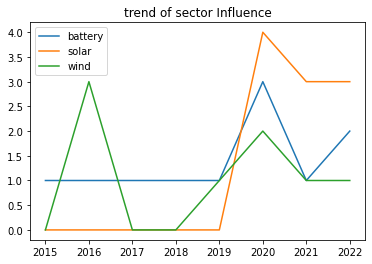

In [ ]:
plt.plot(fin.groupby(['year']).sum())
plt.legend(labels=['battery','solar', 'wind'])
plt.title('trend of sector Influence')

In [ ]:
fin.groupby(['year']).sum().T.sum()

year
2015    1
2016    4
2017    1
2018    1
2019    2
2020    9
2021    5
2022    6
dtype: int64

In [ ]:
fin.groupby(['year']).count().T.iloc[3:].sum()

year
2015    15
2016    18
2017     9
2018     9
2019     9
2020    15
2021    15
2022    15
dtype: int64

Text(0.5, 1.0, 'trend of Influence ratio')

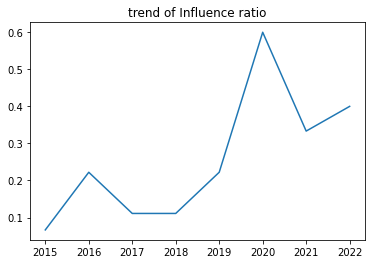

In [ ]:
plt.plot(fin.groupby(['year']).sum().T.sum()/fin.groupby(['year']).count().T.iloc[3:].sum())
plt.title('trend of Influence ratio')

In [ ]:
fin.groupby(['주체']).count().iloc[:,1]

주체
EU       4
UN       6
독일       1
미국정부    10
중국정부     7
한국정부     7
Name: 내용, dtype: int64

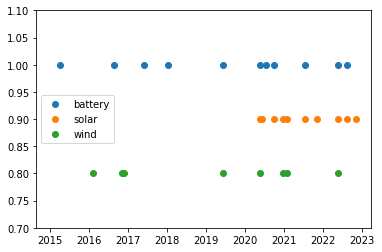

In [ ]:
plt.scatter(fin.iloc[:,[0]], fin.iloc[:,[3]])
plt.scatter(fin.iloc[:,[0]], fin.iloc[:,[4]]*0.9)
plt.scatter(fin.iloc[:,[0]], fin.iloc[:,[5]]*0.8)
plt.ylim(0.7,1.1)
plt.legend(labels=['battery','solar','wind'], loc='center left')